# CIFAR 10

This notebook trains a classifier on CIFAR10 using Tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import os.path
import time
import datetime

In [2]:
# 100 epochs will take ages on CPU, reduce or use GPU
EPOCHS = 150
BATCH_SIZE = 50
LABELS = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

## Load Data

In [3]:
def unpack(batch):
    return batch["image"], batch["label"]

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

In [3]:
def prepare(batch):
    return (
        {
            "image": tf.cast(batch["image"], tf.float32) / 255.,
            "id": batch["id"],
        },
        batch["label"],
    )

In [5]:
train_ds, test_ds = tfds.load("cifar10", split=["train", "test"], data_dir="/tmp/tensorflow_datasets")

Dataset cifar10 downloaded and prepared to /tmp/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [6]:
# split off a chunk of training data for validation
val_ds = train_ds.take(1000)
train_ds = train_ds.skip(1000)

train_ds_unshuffle = (
    train_ds
    .batch(BATCH_SIZE)
    .map(prepare)
)
train_ds = (
    train_ds
    .shuffle(buffer_size=8 * BATCH_SIZE)
    .batch(BATCH_SIZE)
    .map(prepare)
)
val_ds = (
    val_ds
    .batch(BATCH_SIZE)
    .map(prepare)
)
test_ds = (
    test_ds
    .batch(BATCH_SIZE)
    .map(prepare)
)

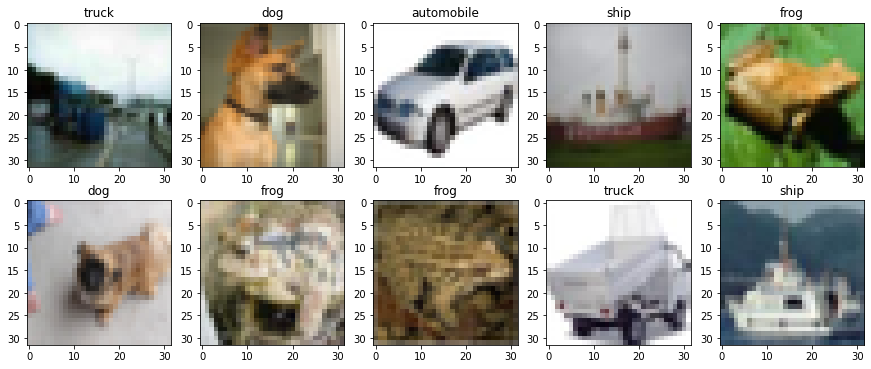

In [17]:
# visualise examples
batch, labels = next(iter(train_ds))
images = batch["image"].numpy()

fig, axes = plt.subplots(2, ncols=5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='binary', interpolation='nearest')
    ax.set_title(LABELS[labels[i]])

## Train Model

### Defining all test models

In [18]:
def build_model(name="model"):
    block = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same", input_shape=(32, 32, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Reshape((2048,)),
        tf.keras.layers.Dense(10)
    ], name=name)
    
    input_ = tf.keras.Input(name="image", shape=(32, 32, 3))
    output = block(input_)
    model = tf.keras.Model(inputs=input_, outputs=output)
    
    model.compile(
        "adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["sparse_categorical_accuracy"])
    
    return model

Creating a checkpoint path to store model trainig history

In [19]:
# checkpoint callback
checkpoint_path = "cp_training_cifar_10/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

BATCHES_PER_EPOCH = int(49000/BATCH_SIZE)

# creating a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,
                                                 save_weights_only=True,
                                                 save_freq=5*BATCHES_PER_EPOCH)

Instantiating a CNN model on the cifar-10 dataset 

In [20]:
model = build_model()
model.summary()

# save model weights
model.save_weights(checkpoint_path.format(epoch=0))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
model (Sequential)           (None, 10)                308394    
Total params: 308,394
Trainable params: 307,946
Non-trainable params: 448
_________________________________________________________________


### Training model

In [25]:
start = time.time()
history = model.fit(train_ds, 
                    epochs=EPOCHS, 
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=[cp_callback, tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=15)])
end = time.time()
print("Total time:", datetime.timedelta(seconds=end - start))

Epoch 1/150
980/980 [==============================] - 6s 6ms/step - loss: 0.3166 - sparse_categorical_accuracy: 0.8873 - val_loss: 0.5844 - val_sparse_categorical_accuracy: 0.8290
Epoch 2/150
707/980 [====================>.........] - ETA: 1s - loss: 0.3195 - sparse_categorical_accuracy: 0.8880
Epoch 00002: saving model to cp_training_cifar_10/cp-0002.ckpt
980/980 [==============================] - 6s 6ms/step - loss: 0.3183 - sparse_categorical_accuracy: 0.8885 - val_loss: 0.5837 - val_sparse_categorical_accuracy: 0.8210
Epoch 3/150
980/980 [==============================] - 6s 6ms/step - loss: 0.3010 - sparse_categorical_accuracy: 0.8941 - val_loss: 0.5774 - val_sparse_categorical_accuracy: 0.8160
Epoch 4/150
980/980 [==============================] - 6s 6ms/step - loss: 0.2917 - sparse_categorical_accuracy: 0.8981 - val_loss: 0.5977 - val_sparse_categorical_accuracy: 0.8160
Epoch 5/150
980/980 [==============================] - 6s 6ms/step - loss: 0.2911 - sparse_categorical_accura

## Results

Summary of the model performance. The defined methods can be used to compare multiple models.

In [26]:
# model plotter
def plot_model_results(history, clr, i="_alt"):
    ax[0].plot(history.history["loss"], "{}".format(clr), label="M{} Train loss".format(i), linewidth=2)
    ax[0].plot(history.history["val_loss"], "{}--".format(clr), label="M{} Val loss".format(i), linewidth=2)
    ax[1].plot(history.history["sparse_categorical_accuracy"], "{}".format(clr), label="M{} Train accuracy".format(i), linewidth=1.5)
    ax[1].plot(history.history["val_sparse_categorical_accuracy"], "{}--".format(clr), label="M{} Val accuracy".format(i), linewidth=1.5)
    ax[0].set_xlabel("$Epochs$", fontsize=16), ax[1].set_xlabel("$Epochs$", fontsize=16)
    ax[0].set_ylabel("$Loss$", fontsize=16), ax[1].set_ylabel("$Accuracy$", fontsize=16)
    ax[0].set_title("Loss", fontsize=18), ax[1].set_title("Accuracy", fontsize=18)
    ax[0].legend(frameon=False, fontsize=14), ax[1].legend(frameon=False, fontsize=14)
    
# print results
def return_results(model, test_ds, i="0"):
    # Evaluate model comparison
    test_batch, test_labels = next(iter(test_ds))
    loss, acc = model.evaluate(test_batch, test_labels, verbose=0)
    print("M{}|| Accuracy: {:.2f}% --- Loss: {:.2f}".format(i, 100 * acc, loss))

M0|| Accuracy: 86.00% --- Loss: 0.47


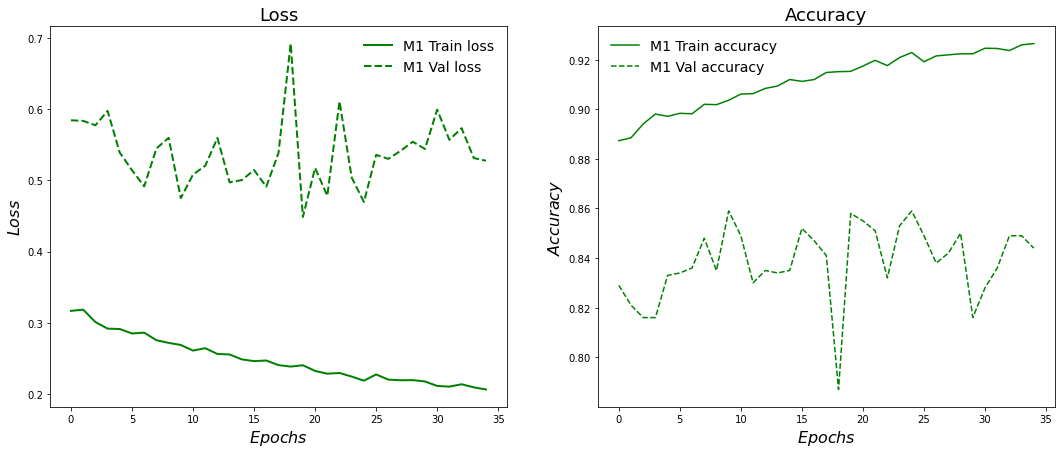

In [27]:
# print result summary 
return_results(model, test_ds)

# create a loss & accuracy subplot
f, ax = plt.subplots(figsize=(18, 7), ncols=2)

# plot results of each model
plot_model_results(history, "g", 1)

## Self Influence 
#### Incorprating the self-influence code outlined in [TracIn paper](https://github.com/frederick0329/TracIn/blob/master/imagenet/resnet50_imagenet_self_influence.ipynb). 

Method below calculations the self-influence (memorisation) score of a given training example for a given batch of images & labels and model checkpoints. Outputs from **run_self_influence** are concatenated into a dictionary using **memorisation_results** to simplify output. The indexing can be taken as the ID across each result member.

In [28]:
# method to calculate self-influence of batch members.
@tf.function
def run_self_influence(images, labels, models):
    self_influences = []
    for m in models:
        with tf.GradientTape(watch_accessed_variables=False) as tape:
            tape.watch(m.trainable_weights)
            probs = m(images)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, probs)
        grads = tape.jacobian(loss, m.trainable_weights)
        scores = tf.add_n([tf.math.reduce_sum(
            grad * grad, axis=tf.range(1, tf.rank(grad), 1)) 
            for grad in grads])
        self_influences.append(scores)  

    # Using probs from last checkpoint
    probs, predicted_labels = tf.math.top_k(probs, k=1)
    return tf.math.reduce_sum(tf.stack(self_influences, axis=-1), axis=-1), labels, probs, predicted_labels

# method to concatenate all of the batch results together
def memorisation_results(memorisation, images, labels, probs, predicted_labels):
    result_dictionary = {
        "memorisation": np.array(np.concatenate(memorisation)),
        "images": np.concatenate(images),
        "labels": np.concatenate(labels),
        "probs": np.concatenate(probs),
        "predicted_labels": np.concatenate(predicted_labels)
    }
    return result_dictionary

This method incorprates **run_self_influence** and **memorisation_results** to return results for any given model scenario. It is used to study the comparisons between different CP memorisation scores.

In [11]:
def return_self_influence_results(train_ds_unshuffle, models):
    ds_memorisation = []
    ds_images = []
    ds_labels = []
    ds_probs = []
    ds_predicted_labels = []

    start = time.time()
    for images, labels in train_ds_unshuffle:
        memorisation_score, labels, probs, predictied_labels = run_self_influence(images, labels, models)
        ds_memorisation.append(memorisation_score)
        ds_images.append(images)
        ds_labels.append(labels)
        ds_probs.append(probs)
        ds_predicted_labels.append(predictied_labels)
    end = time.time()
    print("Total time:", datetime.timedelta(seconds=end - start))
    
    return memorisation_results(ds_memorisation, ds_images, ds_labels, ds_probs, ds_predicted_labels)

A method to load the desired model weights of a single or a list of epochs.

In [12]:
def return_models(epochs):
    loaded_models = []
    for epoch in epochs:
        path = "{}/cp_training_cifar_10/cp-00{:02d}.ckpt.index".format(os.getcwd(), epoch)
        if os.path.exists(path) == False:
            print ("File not found: cp-00{:02d}.ckpt.index".format(epoch))
        else:
            model = build_model()
            model.load_weights("cp_training_cifar_10/cp-00{:02d}.ckpt".format(epoch))
            loaded_models.append(model)
    return loaded_models

### Experimentation

Load models from different epochs to calculate CP memorisation

In [13]:
# define multiple models for selected epochs to examine evolution of memorisation
full_cp = return_models([10, 20, 30, 40, 50])
model_10 = return_models([10])
model_20 = return_models([20])
model_30 = return_models([30])
model_40 = return_models([40])
model_50 = return_models([50])
model_60 = return_models([60])

In [15]:
# running experiments using full_cp list
results_full_cp = return_self_influence_results(train_ds_unshuffle, full_cp)

KeyboardInterrupt: 

In [14]:
# running experiments using specific epochs during training
results_epoch_10 = return_self_influence_results(train_ds_unshuffle, model_10)
results_epoch_20 = return_self_influence_results(train_ds_unshuffle, model_20)
results_epoch_30 = return_self_influence_results(train_ds_unshuffle, model_30)
results_epoch_40 = return_self_influence_results(train_ds_unshuffle, model_40)
results_epoch_50 = return_self_influence_results(train_ds_unshuffle, model_50)
results_epoch_60 = return_self_influence_results(train_ds_unshuffle, model_60)

Total time: 0:03:03.346295
Total time: 0:03:03.487124
Total time: 0:03:03.276059
Total time: 0:03:02.485197
Total time: 0:03:03.659614
Total time: 0:03:02.525057


### Analyse and visualise memorisation results

Running the self influence method over the entire training dataset in batches. The output for memorisation score, labels and probabilities are stored in lists specified.

In [ ]:
# summery of results
print("Total examples with zero influence: {}".format(len([i for i in results_full_cp.get("memorisation") if i == 0])))

X = [i for i in results_full_cp.get("memorisation") if i != 0 and i < 20000]

### Visualise results

In [ ]:
# influence distribution
plt.figure(figsize=(10,5))
plt.hist(X, bins=100, alpha = 0.5)

#plt.xscale('log')
plt.gca().set(xlabel="$Self-influence$", ylabel="$Frequency$")

In [ ]:
X = [i for i in results_epoch_50.get("memorisation") if i == 0]
len(X)

[Text(0, 0.5, '$Counts$'), Text(0.5, 0, '$Self\\ Influence$')]

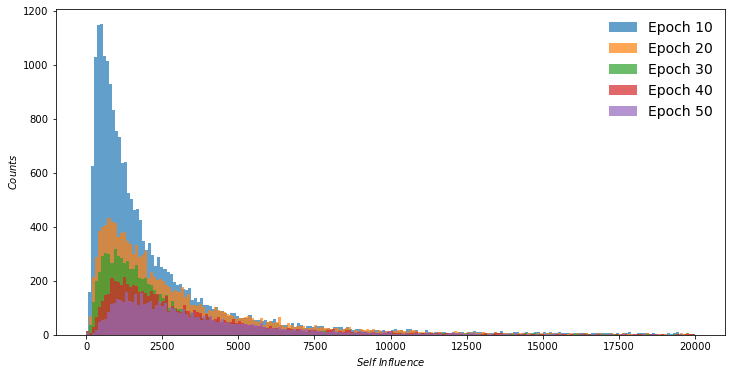

In [16]:
# apply cuts

#X_full = [i for i in results_full_cp.get("memorisation") if i > 1 and i < 20000]
X_10 = [i for i in results_epoch_10.get("memorisation") if i > 1 and i < 20000]
X_20 = [i for i in results_epoch_20.get("memorisation") if i > 1 and i < 20000]
X_30 = [i for i in results_epoch_30.get("memorisation") if i > 1 and i < 20000]
X_40 = [i for i in results_epoch_40.get("memorisation") if i > 1 and i < 20000]
X_50 = [i for i in results_epoch_50.get("memorisation") if i > 1 and i < 20000]
X_60 = [i for i in results_epoch_60.get("memorisation") if i > 1 and i < 20000]


# plot options
bins = 200
alpha = 0.7

# influence distribution of multiple models
plt.figure(figsize=(12,6))
#plt.hist(X_full, bins=bins, alpha=alpha, label="Full CP")
plt.hist(X_10, bins=bins, alpha=alpha, label="Epoch 10")
plt.hist(X_20, bins=bins, alpha=alpha, label="Epoch 20")
plt.hist(X_30, bins=bins, alpha=alpha, label="Epoch 30")
plt.hist(X_40, bins=bins, alpha=alpha, label="Epoch 40")
plt.hist(X_50, bins=bins, alpha=alpha, label="Epoch 50")
plt.legend(frameon=False, fontsize=14)
#plt.yscale('log')
#plt.xscale('log')
plt.gca().set(xlabel="$Self\ Influence$", ylabel="$Counts$")